Import Necessary libraries

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
from math import sqrt
import os

Mount Google Drive

In [33]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Specify the path to the CSV file of the dataset on Google Drive

In [34]:
file_path = '/content/drive/MyDrive/Deep_Learning/Project02/CSE_Data.csv'
file_exists = os.path.exists(file_path)
if file_exists:
    print("File loaded successfully.")
else:
    print("File not found.")

File loaded successfully.


Load Data

In [35]:
data = pd.read_csv(file_path)
prices = data['Price'].values.reshape(-1, 1)

Normalize data

In [58]:
prices_float = np.array([float(price.replace(',', '')) for price in prices.ravel()]).reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
prices_normalized = scaler.fit_transform(prices_float)

Split data into training and testing sets

In [59]:
split_ratio = 0.8
split_index = int(len(prices_normalized) * split_ratio)
train_data = prices_normalized[:split_index]
test_data = prices_normalized[split_index:]

Prepare data for LSTM

In [60]:
def create_dataset(dataset, time_steps=1):
    x, y = [], []
    for i in range(len(dataset) - time_steps):
        a = dataset[i:(i + time_steps), 0]
        x.append(a)
        y.append(dataset[i + time_steps, 0])
    return np.array(x), np.array(y)

time_steps = 20
X_train, y_train = create_dataset(train_data, time_steps)
X_test, y_test = create_dataset(test_data, time_steps)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

Build LSTM model

In [62]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=100, batch_size=64)

Epoch 1/100
70/70 [==============================] - 8s 49ms/step - loss: 0.0178
Epoch 2/100
70/70 [==============================] - 2s 32ms/step - loss: 3.9106e-04
Epoch 3/100
70/70 [==============================] - 2s 32ms/step - loss: 3.8861e-04
Epoch 4/100
70/70 [==============================] - 2s 31ms/step - loss: 3.7409e-04
Epoch 5/100
70/70 [==============================] - 2s 31ms/step - loss: 3.8079e-04
Epoch 6/100
70/70 [==============================] - 3s 38ms/step - loss: 3.6588e-04
Epoch 7/100
70/70 [==============================] - 4s 56ms/step - loss: 3.6605e-04
Epoch 8/100
70/70 [==============================] - 4s 55ms/step - loss: 3.7604e-04
Epoch 9/100
70/70 [==============================] - 5s 70ms/step - loss: 3.8124e-04
Epoch 10/100
70/70 [==============================] - 3s 49ms/step - loss: 3.8318e-04
Epoch 11/100
70/70 [==============================] - 3s 37ms/step - loss: 3.7733e-04
Epoch 12/100
70/70 [==============================] - 4s 57ms/step 

Predictions

15/15 [==============================] - 1s 9ms/step


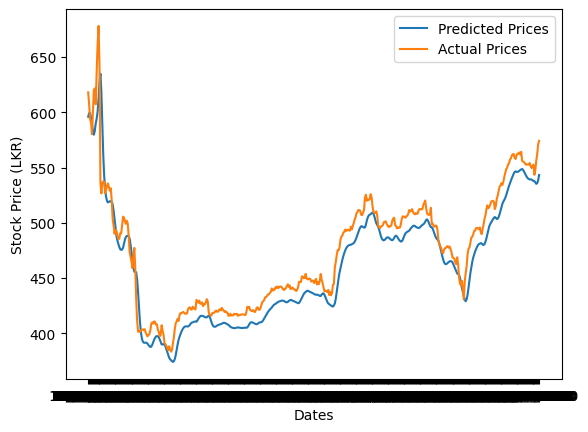

In [63]:
predicted_stock_prices = model.predict(X_test)
predicted_stock_prices = scaler.inverse_transform(predicted_stock_prices.reshape(-1, 1))

plt.plot(data['Date'][split_index + time_steps:], predicted_stock_prices, label='Predicted Prices')
plt.plot(data['Date'][split_index + time_steps:], scaler.inverse_transform(test_data[time_steps:].reshape(-1, 1)),
         label='Actual Prices')
plt.xlabel('Dates')
plt.ylabel('Stock Price (LKR)')
plt.legend()
plt.show()

Comparison of the predicted prices with the actial prices

In [64]:
results_df = pd.DataFrame({
    'Date': data['Date'][split_index + time_steps:],
    'Actual Prices (LKR)': scaler.inverse_transform(test_data[time_steps:].reshape(-1, 1)).flatten(),
    'Predicted Prices (LKR)': predicted_stock_prices.flatten()
})

print(results_df)

            Date  Actual Prices (LKR)  Predicted Prices (LKR)
4520  12/28/2001                618.1              596.043396
4521  12/27/2001                607.0              599.256714
4522  12/21/2001                593.5              599.476807
4523  12/20/2001                591.0              595.633850
4524  12/19/2001                580.2              589.923096
...          ...                  ...                     ...
4995  01/10/2000                547.7              536.497620
4996  01/06/2000                556.5              535.267578
4997  01/05/2000                562.2              535.911438
4998  01/04/2000                571.2              538.573120
4999  01/03/2000                574.2              543.287781

[480 rows x 3 columns]


Assess the performance of the model by computing the Root Mean Squared Error (RMSE)

In [65]:
predicted_stock_prices = model.predict(X_test)
predicted_stock_prices = scaler.inverse_transform(predicted_stock_prices.reshape(-1, 1))

actual_stock_prices = scaler.inverse_transform(test_data[time_steps:].reshape(-1, 1))

rmse = sqrt(mean_squared_error(actual_stock_prices, predicted_stock_prices))
print(f'Root Mean Squared Error (RMSE): {rmse}')

15/15 [==============================] - 0s 8ms/step
Root Mean Squared Error (RMSE): 17.2421137741781
